In [40]:
%matplotlib inline
import pandas as pd
import os
import bidi.algorithm
import arabic_reshaper
import matplotlib.pyplot as plt

In [41]:
fpath = '/media/sf_VBox_Shared/Arabic/Analyses/Fiqh_final2/quotes'
os.listdir(fpath)

['fiqh_quran_aya_nodes.csv',
 'fiqh_quran_book_nodes.csv',
 'fiqh_quran_links.csv',
 'links_projected_books.csv',
 'links_tfidf_books.csv',
 'quotes_merged.csv',
 'quran_quotes.csv']

In [42]:
links_df = pd.read_csv(os.path.join(fpath, 'fiqh_quran_links.csv'))
nodes_aya_df = pd.read_csv(os.path.join(fpath, 'fiqh_quran_aya_nodes.csv'))
nodes_books_df = pd.read_csv(os.path.join(fpath, 'fiqh_quran_book_nodes.csv'))
quotes_df = pd.read_csv(os.path.join(fpath, 'quran_quotes.csv'))

In [43]:
links_df.head()

,Source,Target,Weight
0,0179MalikIbnAnas.Muwatta,"(1.0, 4.0)",1
1,0179MalikIbnAnas.Muwatta,"(1.0, 5.0)",1
2,0179MalikIbnAnas.Muwatta,"(2.0, 156.0)",1
3,0179MalikIbnAnas.Muwatta,"(2.0, 178.0)",2
4,0179MalikIbnAnas.Muwatta,"(2.0, 180.0)",1


In [44]:
nodes_aya_df.head()

,id,sura_id,aya_id,sura_name,sura_arabic_name,Type,Label,Group
0,"(65.0, 2.0)",65,2,At-Talaq,الطلاق,aya,At-Talaq 2,aya
1,"(112.0, 1.0)",112,1,Al-Ikhlas,الإخلاص,aya,Al-Ikhlas 1,aya
2,"(65.0, 4.0)",65,4,At-Talaq,الطلاق,aya,At-Talaq 4,aya
3,"(2.0, 196.0)",2,196,Al-Baqarah,البقرة,aya,Al-Baqarah 196,aya
4,"(24.0, 6.0)",24,6,An-Nur,النور,aya,An-Nur 6,aya


In [45]:
merged_df = links_df.merge(nodes_aya_df, left_on='Target', right_on='id')[['Source', 'Weight', 'sura_id', 'aya_id', 'sura_name', 'sura_arabic_name', 'Label']]
merged_df = merged_df.rename({'Label': 'aya_label'}, axis=1)
merged_df = merged_df.merge(nodes_books_df, left_on='Source', right_on='id')
merged_df = merged_df.drop(['Source', 'id', 'Type', 'Group', 'Label'], axis=1)

In [119]:
merged_df.to_csv(os.path.join(fpath, 'quotes_merged.csv'), index=False)

In [8]:
# Nr of quotes per book (including quotes that were not found using alfanous)
#quotes_df.BookURI.value_counts().plot(kind='bar', figsize=(15,8))

In [46]:
def reshape_arabic(text):
    return bidi.algorithm.get_display(arabic_reshaper.reshape(text))

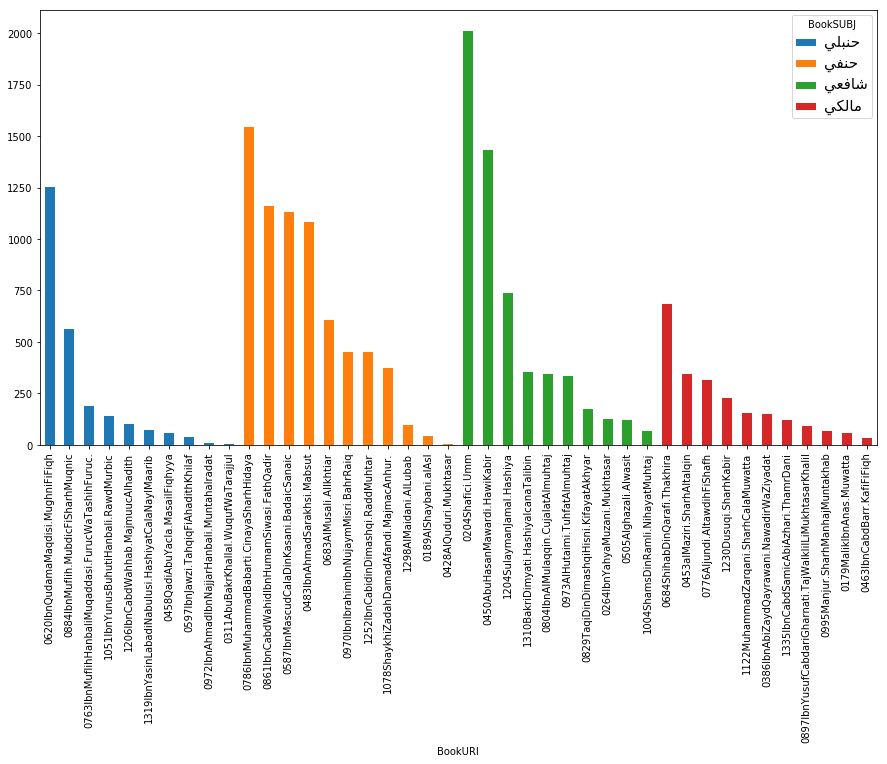

In [47]:
# Nr of quotes per book, sorted per school
count_per_book = merged_df.groupby(['BookURI', 'BookSUBJ'])['Weight'].sum().unstack()
barplot = count_per_book.sort_values(list(count_per_book.columns), ascending=False).plot(kind='bar', stacked=True, figsize=(15,8))
leg = barplot.axes.get_legend()
for t in leg.get_texts():
    t.set_text(reshape_arabic(t.get_text()))
    t.set_fontsize(15)
plt.show()

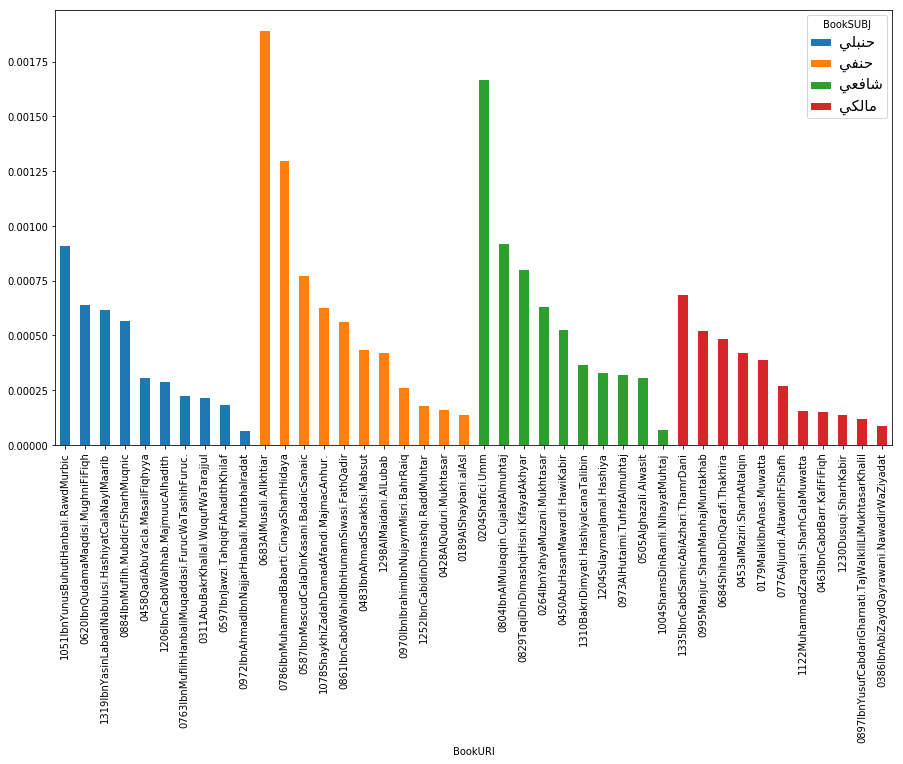

In [48]:
# Relative of quotes per book (divided by length of book) , sorted per school
nr_tokens_per_book = merged_df.groupby(['BookURI', 'BookSUBJ'])['Number_of_tokens'].min()
rel_count_per_book = merged_df.groupby(['BookURI', 'BookSUBJ'])['Weight'].sum() / nr_tokens_per_book
rel_count_per_book = rel_count_per_book.unstack()
barplot = rel_count_per_book.sort_values(list(rel_count_per_book.columns), ascending=False).plot(kind='bar', stacked=True, figsize=(15,8))
leg = barplot.axes.get_legend()
for t in leg.get_texts():
    t.set_text(reshape_arabic(t.get_text()))
    t.set_fontsize(15)
plt.show()

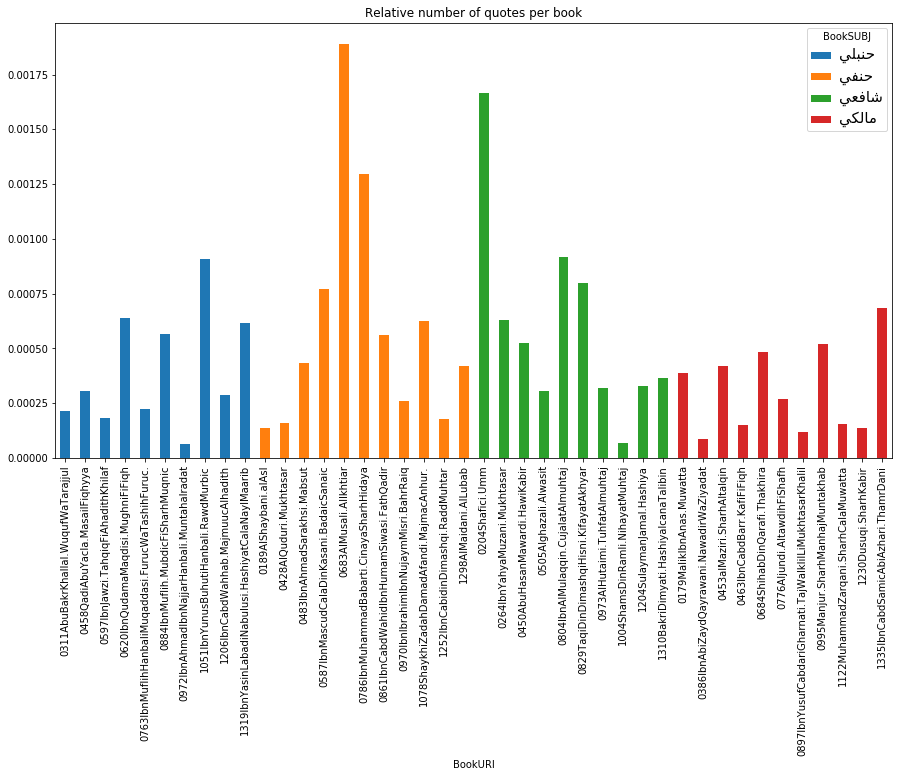

In [117]:
rel_count_per_book = merged_df.groupby(['BookURI', 'BookSUBJ'])['Weight'].sum() / nr_tokens_per_book
rel_count_per_book = rel_count_per_book.reset_index().sort_values(['BookSUBJ', 'BookURI'])
rel_count_per_book = rel_count_per_book.pivot('BookURI', 'BookSUBJ', 0).reindex(rel_count_per_book.BookURI)
barplot = rel_count_per_book.plot(kind='bar', stacked=True, figsize=(15,8))
leg = barplot.axes.get_legend()
for t in leg.get_texts():
    t.set_text(reshape_arabic(t.get_text()))
    t.set_fontsize(15)
plt.title('Relative number of quotes per book')
plt.show()

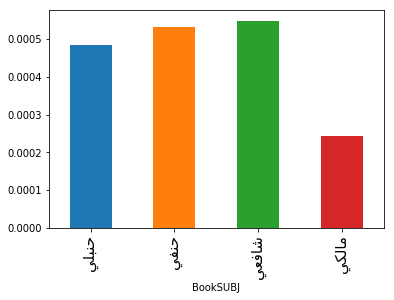

In [118]:
rel_count_per_school = merged_df.groupby('BookSUBJ')['Weight'].sum() / nr_tokens_per_book.groupby('BookSUBJ').sum() 
barplot = rel_count_per_school.plot(kind='bar')
barplot.set_xticklabels([reshape_arabic(t.get_text()) for t in barplot.xaxis.get_ticklabels()])
plt.xticks(fontsize=15)
plt.show()

In [50]:
import re
merged_df['Century_num'] = merged_df.Century.apply(lambda s: int(re.match('^[0-9]*', s).group(0)))

In [51]:
count_per_century_subj = merged_df.groupby(['Century_num', 'BookSUBJ'])['Weight'].sum()

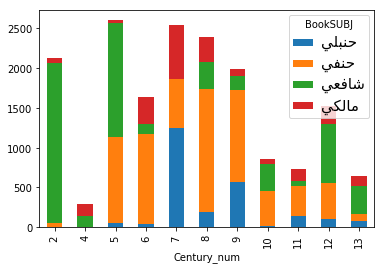

In [52]:
# Total number of quotes per century, per school
barplot = count_per_century_subj.unstack().plot(kind='bar', stacked=True)
leg = barplot.axes.get_legend()
for t in leg.get_texts():
    t.set_text(reshape_arabic(t.get_text()))
    t.set_fontsize(15)
plt.show()

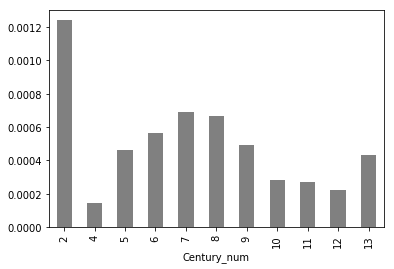

In [66]:
# Relative number of quotes per century
count_per_century = count_per_century_subj.groupby('Century_num').sum()
rel_count_per_century = count_per_century / nrtokens_per_century_subj.groupby(['Century_num']).sum() 
barplot = rel_count_per_century.plot(kind='bar', color='grey')
plt.show()

In [69]:
# Which verses are cited most often?
counts_per_verse = pd.DataFrame({'nr_books': merged_df.aya_label.value_counts(), 
                                 'nr_citations': merged_df.groupby('aya_label')['Weight'].sum()})
counts_per_verse.sort_values('nr_citations', ascending=False).head(20)

,nr_books,nr_citations
Al-Baqarah 196,29,247
Al-Baqarah 282,28,242
An-Nisa' 23,29,232
An-Nisa' 43,32,217
An-Nisa' 11,28,209
Al-Ma'idah 6,30,209
Al-Ma'idah 95,29,205
Al-Baqarah 233,24,165
Al-Baqarah 229,27,165
Al-Baqarah 228,28,152


In [70]:
# What are the verses cited by most books?
counts_per_verse.sort_values('nr_books', ascending=False).head(10)

,nr_books,nr_citations
An-Nisa' 43,32,217
Al-Ma'idah 6,30,209
Al-Baqarah 196,29,247
Al-Ma'idah 95,29,205
An-Nisa' 23,29,232
An-Nisa' 11,28,209
Al-Baqarah 282,28,242
Al-Baqarah 228,28,152
Al-Baqarah 185,27,79
At-Tawba 103,27,90


In [71]:
from IPython.display import display
# What are the verses cited by most books, per school?
for school in merged_df.BookSUBJ.unique():
    print(school)
    df_sub = merged_df[merged_df.BookSUBJ==school]
    counts_per_verse_sub = pd.DataFrame({'nr_books': df_sub.aya_label.value_counts(), 
                                 'nr_citations': df_sub.groupby('aya_label')['Weight'].sum()})
    print('Nr of books: ', df_sub.BookURI.nunique())
    display(counts_per_verse_sub.sort_values('nr_citations', ascending=False).head(20))
    print('\n')

مالكي
Nr of books:  11


,nr_books,nr_citations
An-Naziat 20,1,51
An-Nisa' 11,7,40
Al-Ma'idah 6,6,33
An-Nisa' 43,7,32
An-Nisa' 23,6,29
Al-Baqarah 282,6,27
An-Nisa' 6,4,24
Al-Ma'idah 45,7,20
Al-Baqarah 283,4,20
Al-Baqarah 196,5,19




شافعي
Nr of books:  10


,nr_books,nr_citations
Al-Baqarah 282,9,117
Al-Baqarah 229,9,85
An-Nisa' 43,10,82
Al-Ma'idah 95,9,82
Al-Baqarah 196,9,78
At-Talaq 2,9,72
Al-Ma'idah 6,9,65
An-Nisa' 23,9,63
Al-Baqarah 228,8,58
Al-Baqarah 237,8,55




حنفي
Nr of books:  11


,nr_books,nr_citations
Al-Baqarah 196,10,115
An-Nisa' 23,9,103
Al-Baqarah 233,9,103
An-Nisa' 11,9,84
Al-Ma'idah 6,10,80
Al-Ma'idah 95,9,77
Al-Baqarah 282,9,76
An-Nisa' 43,9,74
At-Talaq 4,9,70
An-Nisa' 24,8,68




حنبلي
Nr of books:  10


,nr_books,nr_citations
An-Nisa' 23,5,37
Al-Baqarah 196,5,35
An-Nisa' 11,4,32
Al-Ma'idah 95,6,31
Al-Ma'idah 6,5,31
An-Nisa' 43,6,29
Al-Mujadila 3,5,28
Al-Ma'idah 45,4,26
Al-Ikhlas 1,7,24
Al-Baqarah 184,5,24


## NLP approaches

In [72]:
adj_df = merged_df.pivot('BookURI', 'aya_label', 'Weight').fillna(0)

In [73]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf = tfidf_transformer.fit_transform(adj_df.values)
print(tfidf.shape)

(42, 2406)


In [74]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(tfidf, tfidf)
similarities.shape

(42, 42)

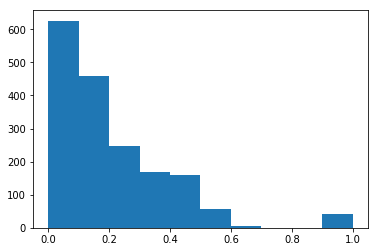

In [75]:
plt.hist(similarities.flatten());

In [76]:
import numpy as np
similarities_df = pd.DataFrame(similarities, columns=adj_df.index, index=adj_df.index)
np.fill_diagonal(similarities_df.values, 0)

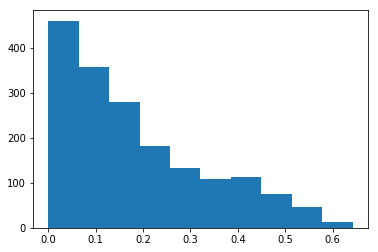

In [77]:
plt.hist(similarities_df.values.flatten());

In [78]:
from sklearn.metrics.pairwise import cosine_distances

from sklearn.manifold import TSNE

dist = cosine_distances(tfidf, tfidf)

X_embedded = TSNE(n_components=2, metric='precomputed').fit_transform(dist)
print(X_embedded.shape)

(42, 2)


In [79]:
df_books_embedded = pd.DataFrame(X_embedded, index=adj_df.index, columns=['x', 'y'])

In [80]:
df_books_embedded.head()

,x,y
BookURI,,
0179MalikIbnAnas.Muwatta,-69.778320,37.566395
0189AlShaybani.alAsl,-54.279499,67.094429
0204Shafici.Umm,-10.350084,9.151305
0264IbnYahyaMuzani.Mukhtasar,18.680958,-28.978422
0311AbuBakrKhallal.WuqufWaTarajjul,-106.703033,45.966461


In [81]:
df_books_embedded = df_books_embedded.merge(nodes_books_df, right_on='BookURI', left_on='BookURI')

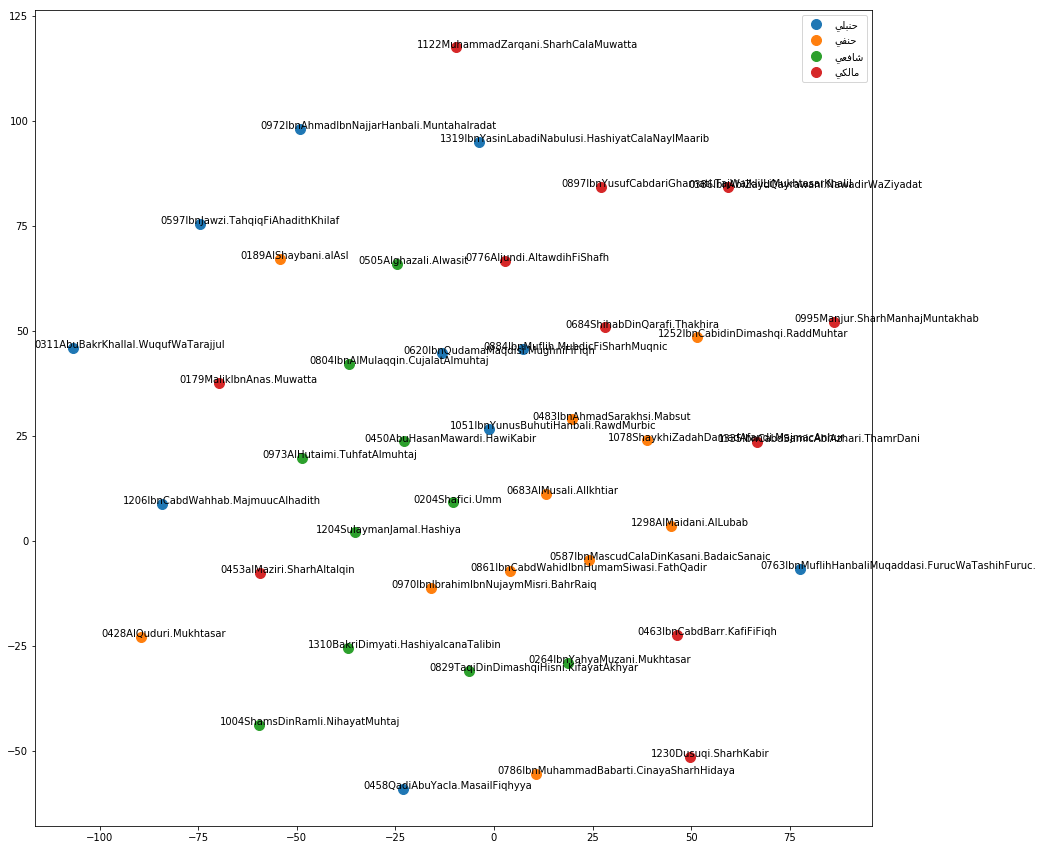

In [82]:
fig, ax = plt.subplots(figsize=(15,15))
for subj, group in df_books_embedded.groupby('BookSUBJ'):
    ax.plot(group.x, group.y, label=reshape_arabic(subj), marker='o', linestyle='', markersize=10)
    for x,y,s in zip(group.x, group.y, group.BookURI):
        ax.text(x-10, y, s)
ax.legend()
plt.show()

## Network analysis

In [104]:
import networkx as nx

In [105]:
nw_similarities = nx.from_pandas_adjacency(similarities_df)
list(nw_similarities.edges(data=True))[:10]

[('0179MalikIbnAnas.Muwatta',
  '0189AlShaybani.alAsl',
  {'weight': 0.0587153201562486}),
 ('0179MalikIbnAnas.Muwatta',
  '0204Shafici.Umm',
  {'weight': 0.2301601481975677}),
 ('0179MalikIbnAnas.Muwatta',
  '0264IbnYahyaMuzani.Mukhtasar',
  {'weight': 0.11823540457824286}),
 ('0179MalikIbnAnas.Muwatta',
  '0386IbnAbiZaydQayrawani.NawadirWaZiyadat',
  {'weight': 0.08265935054714874}),
 ('0179MalikIbnAnas.Muwatta',
  '0450AbuHasanMawardi.HawiKabir',
  {'weight': 0.16582454070539274}),
 ('0179MalikIbnAnas.Muwatta',
  '0453alMaziri.SharhAltalqin',
  {'weight': 0.03350340128348844}),
 ('0179MalikIbnAnas.Muwatta',
  '0458QadiAbuYacla.MasailFiqhyya',
  {'weight': 0.05633853153888774}),
 ('0179MalikIbnAnas.Muwatta',
  '0463IbnCabdBarr.KafiFiFiqh',
  {'weight': 0.06217425970694872}),
 ('0179MalikIbnAnas.Muwatta',
  '0483IbnAhmadSarakhsi.Mabsut',
  {'weight': 0.19971305803085115}),
 ('0179MalikIbnAnas.Muwatta',
  '0505Alghazali.Alwasit',
  {'weight': 0.14080803019709603})]

In [106]:
nx.to_pandas_edgelist(nw_similarities).to_csv(os.path.join(fpath, 'links_tfidf_books.csv'), index=False)

In [74]:
network = nx.from_pandas_edgelist(links_df, source='Source', target='Target', edge_attr='Weight')

In [75]:
nx.algorithms.is_bipartite(network)

True

In [76]:
# Get projected graphs
book_ids = links_df.Source.unique()
nw_books_jaccard = nx.algorithms.bipartite.overlap_weighted_projected_graph(network, book_ids)
nw_books_overlap

In [79]:
list(nw_books.edges(data=True))[:10]

[('0179MalikIbnAnas.Muwatta',
  '1310BakriDimyati.HashiyaIcanaTalibin',
  {'weight': 0.07450980392156863}),
 ('0179MalikIbnAnas.Muwatta',
  '1204SulaymanJamal.Hashiya',
  {'weight': 0.061611374407582936}),
 ('0179MalikIbnAnas.Muwatta',
  '1319IbnYasinLabadiNabulusi.HashiyatCalaNaylMaarib',
  {'weight': 0.07142857142857142}),
 ('0179MalikIbnAnas.Muwatta',
  '0786IbnMuhammadBabarti.CinayaSharhHidaya',
  {'weight': 0.07666666666666666}),
 ('0179MalikIbnAnas.Muwatta',
  '1051IbnYunusBuhutiHanbali.RawdMurbic',
  {'weight': 0.16101694915254236}),
 ('0179MalikIbnAnas.Muwatta',
  '0483IbnAhmadSarakhsi.Mabsut',
  {'weight': 0.05450733752620545}),
 ('0179MalikIbnAnas.Muwatta', '0683AlMusali.AlIkhtiar', {'weight': 0.08125}),
 ('0179MalikIbnAnas.Muwatta',
  '0587IbnMascudCalaDinKasani.BadaicSanaic',
  {'weight': 0.06205250596658711}),
 ('0179MalikIbnAnas.Muwatta',
  '0264IbnYahyaMuzani.Mukhtasar',
  {'weight': 0.08870967741935484}),
 ('0179MalikIbnAnas.Muwatta',
  '1004ShamsDinRamli.NihayatMuhtaj'

In [77]:
nx.to_pandas_edgelist(nw_books).to_csv(os.path.join(fpath, 'links_projected_books.csv'), index=False)